<center><h1>N1: Métodos de clustering</h1></center>

# N1.3: Métodos de clustering espectral


# RECUERDA RELLENAR TUS DATOS A CONTINUACIÓN ANTES DE HACER NADA

In [1]:
# ===============================================================#
# Rellena AQUÍ tu nombre y apellidos antes de hacer nada
# ===============================================================#

NOMBRE = 'CarlosEsteban'
APELLIDOS = 'PosadaMejia'

# ===============================================================#
# NO MODIFIQUES ESTA PORCIÓN DE CÓDIGO, ES PARA LA EVALUACIÓN
# MUY IMPORTANTE: NO MODIFICAR
# ===============================================================#
from matplotlib.backends.backend_agg import FigureCanvasAgg
def encode_figure(fig):
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    img, (width, height) = canvas.print_to_buffer()
    return {'img': img, 'width': width, 'height': height}

answers = {}
answers['name'] = NOMBRE
answers['surname'] = APELLIDOS
answers['subject'] = '06MAIR_10_A_2020-21_ANS'
answers['ex'] = 'N1.3'
# ===============================================================#

En esta práctica vamos a poner en práctica los conceptos vistos en clase relacionados con los métodos de clustering espectral.


Para comenzar, cargamos tanto las librerías necesarias como el conjunto de datos con el que trabajaremos:


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it

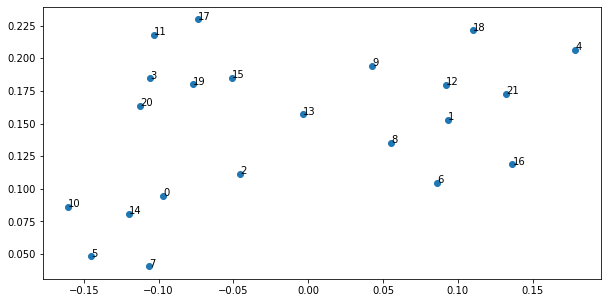

In [3]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_reducido.csv'
#data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_circulos_concentricos.csv'
#data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_cuatro_diferente_medida.csv'
#data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_inseparable.csv'
#data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_dos_remolinos.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False),:]
Dx = D[:,:2]
#Dy = D[:,2]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1])#, c = Dy)
for i, txt in enumerate(range(Dx.shape[0])):
    ax.annotate(txt, Dx[i])


Antes de comenzar, cargamos la función que nos permite dibujar el grafo de afinidad:


In [4]:
def plt_grafo_afinidad(Dx, A):
    minVal = np.min(A[np.nonzero(A)])
    aux = (A-minVal)/(np.max(A)-minVal)
    W = np.zeros(A.shape)
    W[np.nonzero(A)] = 5*(aux[np.nonzero(A)]+.1)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(Dx[:,0],Dx[:,1])
    for i, txt in enumerate(range(Dx.shape[0])):
        ax.annotate(txt, Dx[i])
    inds = np.where(A>0)
    for i in np.arange(1,inds[0].size):
        ax.plot([Dx[inds[0][i],0],Dx[inds[1][i],0]],[Dx[inds[0][i],1],Dx[inds[1][i],1]], 
                linestyle='-', linewidth=W[inds[0][i],inds[1][i]],c='red')


En agrupamiento espectral trabajamos con la matriz de similitudes. Dada la matriz de distancias (euclidiana) que obtenemos con la funcion euclidean_distances de la librería scikit-learn, se calcula la matriz de similitud de la siguiente manera:


In [5]:
from sklearn.metrics.pairwise import euclidean_distances

sigma = 0.1

mSimilitud = euclidean_distances(Dx)
mSimilitud = np.exp(-np.power(mSimilitud,2)/(2*sigma**2))


Se puede construir un grafo de afinidad a partir de una matriz de similitud de diferentes maneras. Una de ellas es mediante el procedimiento de los vecinos más cercanos. Cada ejemplo se enlaza con sus $K$ vecinos más cercanos. A la hora de darle peso a cada arista, existen también diferentes apreciaciones. Una de las más sencillas sería asignar peso $1$ a la arista entre dos nodos $(e,f)$ si $e$ es uno de los $K$ vecinos más cercanos de $f$ y $f$ lo es de $e$. Se asignaría peso $0.5$ si sólo se cumpliese en un sentido. También se podría asignar un peso en función de la distancia entre nodos.

En este ejemplo, veremos el más sencillo: asignar $1$ o $0.5$.

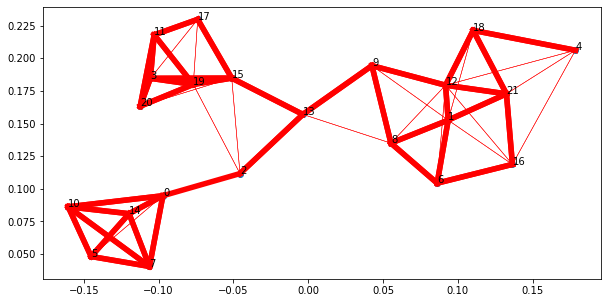

In [6]:
KNN = 4

# No queremos que un nodo sea vecino más cercano de si mismo
np.fill_diagonal(mSimilitud, 0)

W = np.zeros(mSimilitud.shape)
a = (np.argsort(-mSimilitud, axis=0)[0:KNN,:]).flatten()
b = np.tile(np.arange(mSimilitud.shape[0]),KNN)
W[a,b] = 1

a = np.repeat(np.arange(mSimilitud.shape[0]),KNN)
b = (np.argsort(-mSimilitud, axis=1)[:,0:KNN]).flatten()
W[a,b] += 1

W /= 2

plt_grafo_afinidad(Dx, W)

In [7]:
# ## Haré mi propia W con knn
# W = np.zeros(mSimilitud.shape)
# KNN = 4
# for i, fila in enumerate(mSimilitud):
#     print(fila)
#     indices_vecinos =  np.argsort(-fila)[:KNN]
#     print(indices_vecinos)

#     # Actualizo la matriz de conexiones
#     W[i, indices_vecinos] += 0.5 #
#     W[indices_vecinos, i] += 0.5 #
#     print()
#     print()



En la parte de teoría afirmábamos que un algoritmo de agrupamiento sobre un conjunto de datos puede verse como un algoritmo de corte sobre el grafo de afinidad correspondiente.

Para explicar qué es un algoritmo de corte es necesario explicar la función de corte. Ésta es una función que se define sobre un grafo y dos subgrupos complementarios de los nodos del grafo. La función corte cuenta el número de aristas que unen ambos subconjuntos de nodos. Si las aristas tienen un peso asignado, la función se define como la suma de los pesos de las aristas que unen ambos subconjuntos de nodos:


In [8]:
# tanto A como B son vectores con los índices de los nodos pertenecientes a cada
# subconjunto
# W es la matriz de afinidad
def corte(W, A, B):
    return np.sum([[W[i, j] for j in B] for i in A])


Un algoritmo de corte busca en un grafo la separación en dos que minimiza la función de corte. Aunque existen aproximaciones eficientes (ver Algoritmo de Karger, https://en.wikipedia.org/wiki/Karger%27s_algorithm), la búsqueda del mejor corte por fuerza bruta se convierte rápidamente en inabarcable. Por eso, la limitamos a un número máximo de cortes 'stop_at':


El valor de corte mínimo es:  2.5
La separación que obtuvo corte mínimo es:  [{4}, {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}]


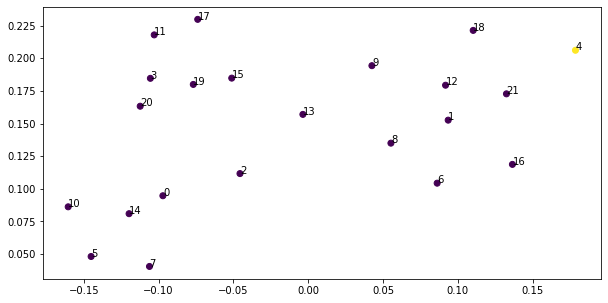

In [9]:
minCorte = np.inf
minAB = []
resCorteNorm = np.array([])
stop_at = 10000
for r in np.arange(1,W.shape[0]):
    for A in it.combinations(np.arange(W.shape[0]), r):        
        B = set(np.arange(W.shape[0]))-set(A)
        actCorte = corte(W, A, B)
        stop_at -= 1
        if actCorte < minCorte:
            minCorte = actCorte
            minAB = [set(A),B]
        if stop_at <= 0.:
            break

print('El valor de corte mínimo es: ', minCorte)
print('La separación que obtuvo corte mínimo es: ', minAB)

colores = np.zeros(Dx.shape[0])
colores[list(minAB[0])] = 1

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = colores)
for i, txt in enumerate(range(Dx.shape[0])):
    ax.annotate(txt, Dx[i])


# INICIO - NO TOCAR : necesario para la evaluación del notebook
answers['1'] = {'minCorte': minCorte, 
                'minAB': minAB,
                'fig': encode_figure(fig)}
# FIN - NO TOCAR : necesario para la evaluación del notebook

Sin embargo, como se puede ver en el resultado anterior, por definición de la función de corte, este algoritmo básico tiende a devolver particiones extremas (ej., sólo un nodo en una de las particiones). Es por ello que en la práctica suele usarse la función de corte normalizado.

Vamos a definir la funcion grado, la cual nos permitirá calcular el número de arcos que conectan a un nodo con otros nodos del grafo, o en el caso de un grafor con pesos, la suma de los pesos de los arcos que lo conectan a otros nodos del grafo:

$d_i = \sum_{i': e_{ii} \in E}w_{ii'}$.

Para ello, teniendo en cuenta que nuestra matriz de afinidad $W$ está definida por filas, bastará con sumar, para el nodo en cuestión $i$, todos los elementos que le correspondan. Es decir, todos los elementos de la fila $i$.

También definiremos la función de corte normalizado.


In [10]:
def grado(W, i):
    return np.sum(W[i])## Tu código aquí ##

def corte_normalizado(W, G, A, B):
    normal = 1. / np.sum([G[i] for i in A]) + 1. / np.sum([G[j] for j in B])
    
    return normal * corte(W, A, B)


Se puede volver a hacer la prueba de la búsqueda del mejor corte por fuerza bruta (limitada a un número máximo de cortes 'stop_at'):


100%|██████████| 21/21 [00:00<00:00, 21.51it/s]


El valor de corte mínimo es:  0.27408231368186875
La separación que obtuvo corte mínimo es:  [{10, 5, 14, 7}, {0, 1, 2, 3, 4, 6, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21}]


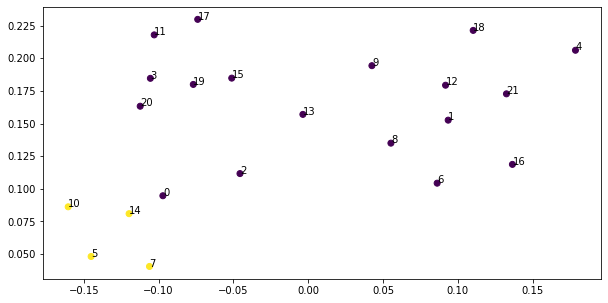

In [11]:
from tqdm import tqdm

D = np.array([grado(W,i) for i in np.arange(W.shape[0])])

minCorte = np.inf
minAB = []
resCorteNorm = np.array([])
stop_at = 10000 # probar incrementando este valor para dar tiempo a encontrar un mejor corte
for r in tqdm(np.arange(1,W.shape[0])):
    for A in it.combinations(np.arange(W.shape[0]), r):        
        B = set(np.arange(W.shape[0]))-set(A)
        # Una vez tenemos un posible corte A-B, calculamos el valor de corte normalizado
        actCorte = corte_normalizado(W, D, A, B)
        stop_at -= 1
        if actCorte < minCorte:
            minCorte = actCorte
            minAB = [set(A),B]
        if stop_at <= 0.:
            break

print('El valor de corte mínimo es: ', minCorte)

print('La separación que obtuvo corte mínimo es: ', minAB)

colores = np.zeros(Dx.shape[0])
colores[list(minAB[0])] = 1

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = colores)
for i, txt in enumerate(range(Dx.shape[0])):
    ax.annotate(txt, Dx[i])


# INICIO - NO TOCAR : necesario para la evaluación del notebook
answers['2'] = {'D': D, 
                'minCorte': minCorte,
                'minAB': minAB,
                'fig': encode_figure(fig)}
# FIN - NO TOCAR : necesario para la evaluación del notebook


Como puede observarse, el tamaño de las particiones está más compensado al usar la medida de corte normalizado ya que se tiene en cuenta el grado medio de los elementos de ambas particiones.


<hr>

En la teoría hablábamos también de la <b>matriz de transiciones</b> (probabilidad de saltar de un nodo a otro) en uno y en varios saltos. La multiplicación de la matriz de transición por sí misma $n$ veces devuelve la probabilidad de saltar de un nodo a otro en $n$ pasos. 

En primer lugar, definiremos la matriz de transiciones:

In [12]:
mTrans = np.transpose(np.transpose(W)/np.sum(W,axis=0))
print('La matriz de transiciones para los dos primeros ejemplos:\n',mTrans[:2,:])

La matriz de transiciones para los dos primeros ejemplos:
 [[0.         0.         0.22222222 0.         0.         0.11111111
  0.         0.22222222 0.         0.         0.22222222 0.
  0.         0.         0.22222222 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.18181818 0.         0.18181818 0.09090909 0.         0.
  0.18181818 0.         0.         0.         0.09090909 0.
  0.09090909 0.         0.         0.18181818]]



A continuación, calcularemos la matriz de transiciones en $n$ pasos. En este ejemplo, vamos a usar $n = 10$:


In [13]:
mNTrans = mTrans.copy()
n = 500
for r in np.arange(n):
    mNTrans = mNTrans.dot(mTrans)
print('La matriz de transiciones para los dos primeros ejemplos tras n pasos:\n',mNTrans[:2,:])

La matriz de transiciones para los dos primeros ejemplos tras n pasos:
 [[0.05113646 0.06249991 0.03409093 0.05113639 0.02840904 0.03977281
  0.03977267 0.04545464 0.04545449 0.03977268 0.04545464 0.04545457
  0.06818172 0.03977272 0.04545464 0.05681821 0.03977266 0.03409093
  0.03977266 0.05681821 0.03977275 0.05113628]
 [0.05113629 0.06250008 0.03409089 0.05113634 0.02840913 0.03977266
  0.03977278 0.04545447 0.04545459 0.03977276 0.04545447 0.04545453
  0.0681819  0.03977273 0.04545447 0.05681816 0.03977278 0.03409089
  0.03977278 0.05681816 0.03977271 0.05113643]]



Podemos observar la probabilidad de acceder desde cada nodo al resto:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


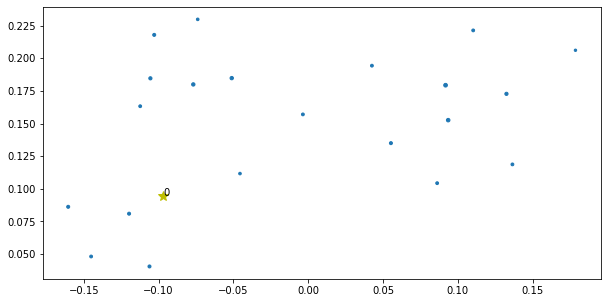

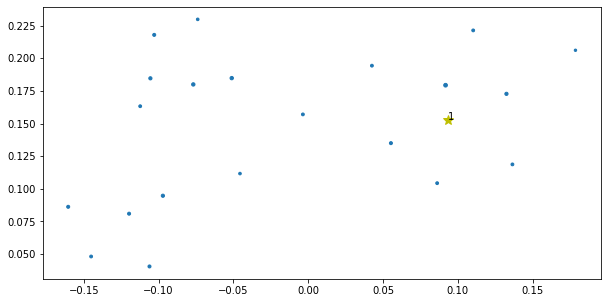

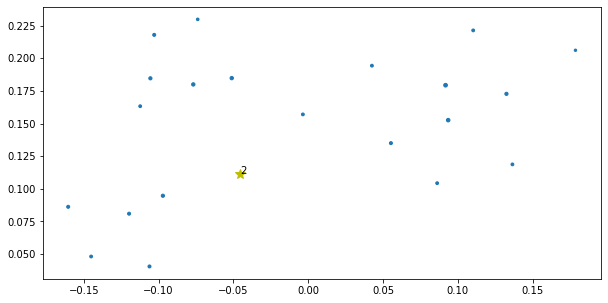

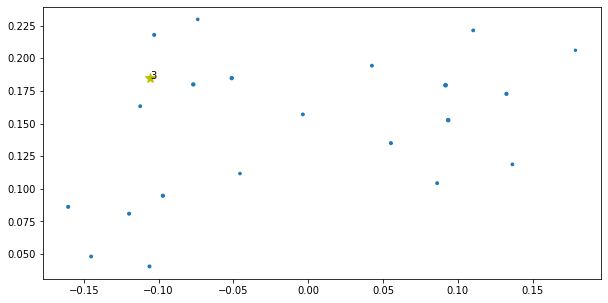

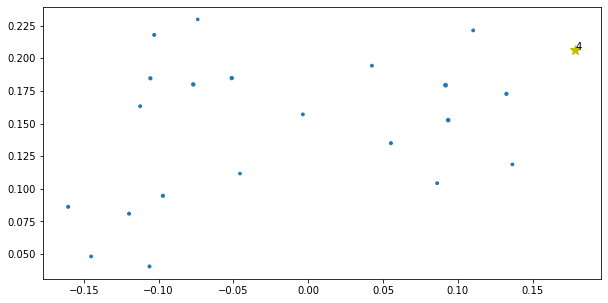

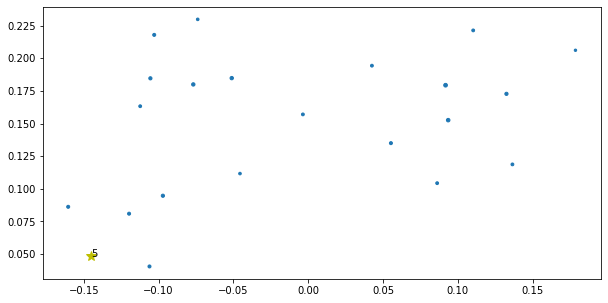

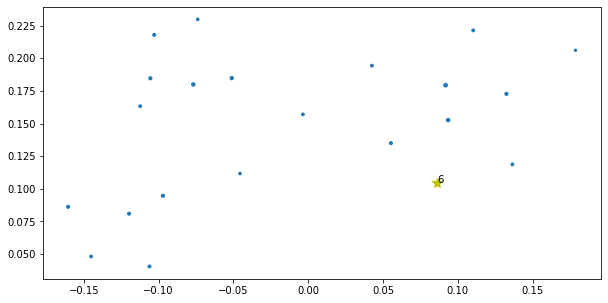

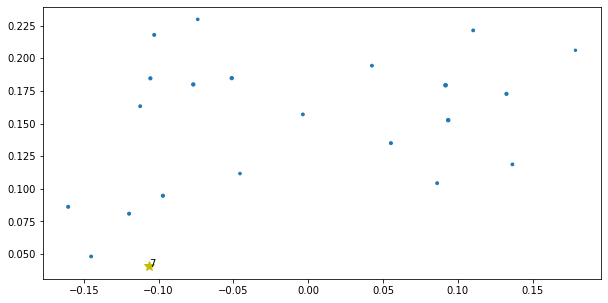

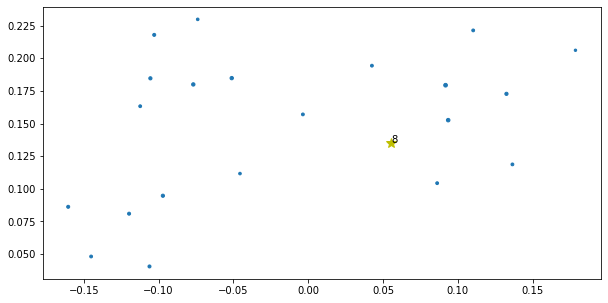

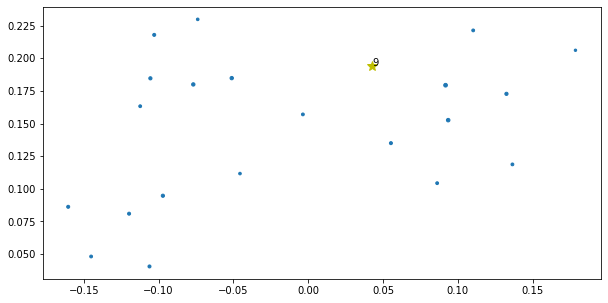

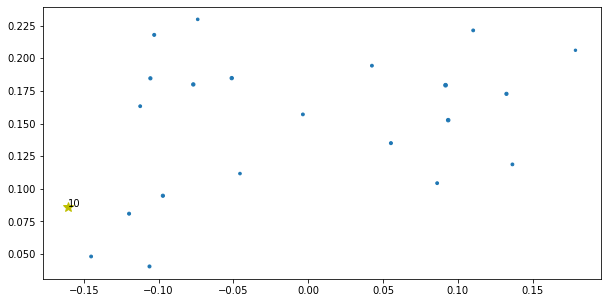

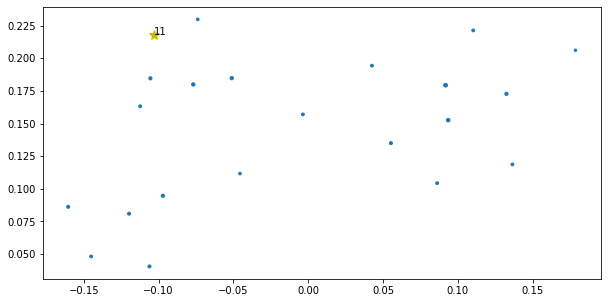

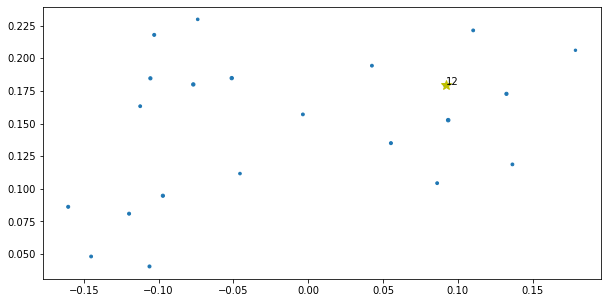

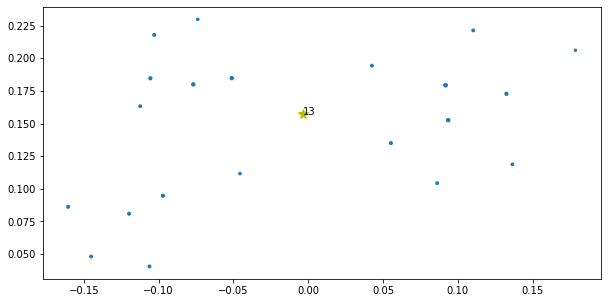

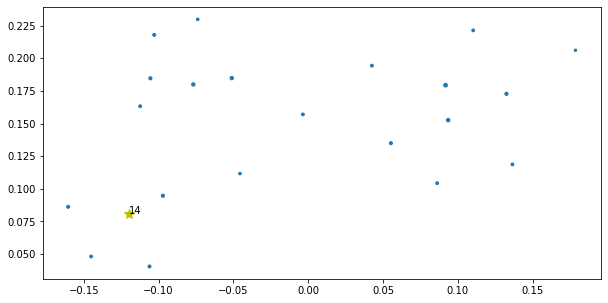

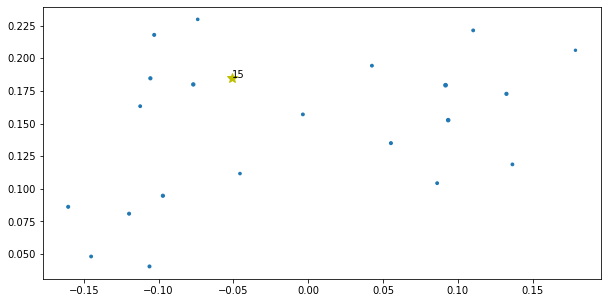

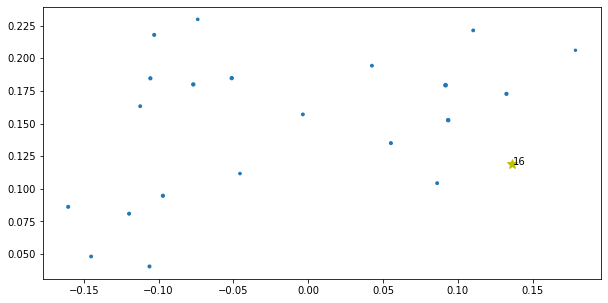

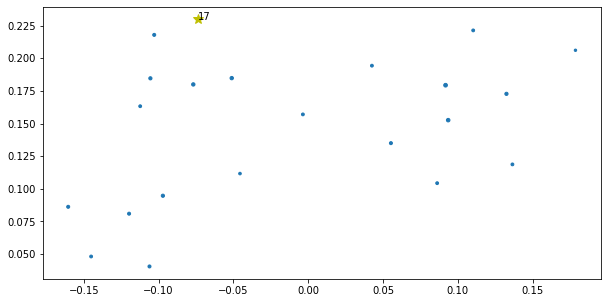

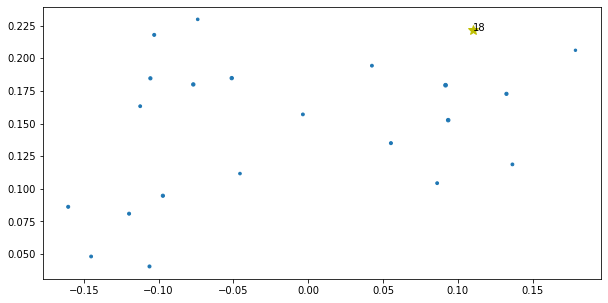

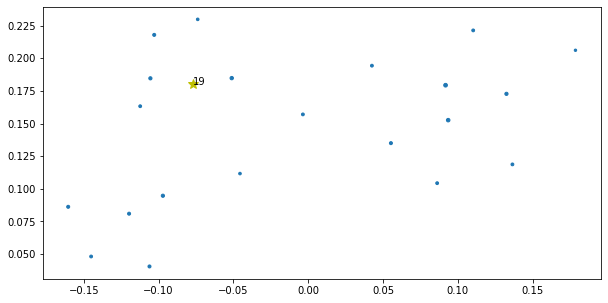

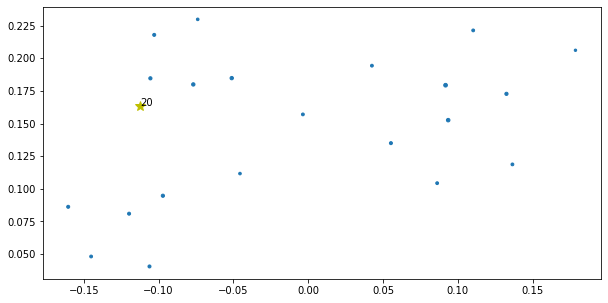

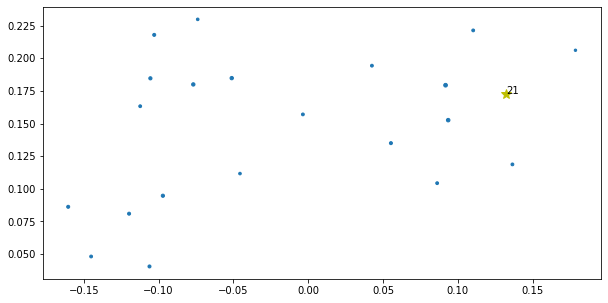

In [14]:
for i in np.arange(Dx.shape[0]):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(Dx[i,0], Dx[i,1], marker='*', markersize=10, color = 'y')
    ax.scatter(Dx[:,0], Dx[:,1], s = 200 * mNTrans[i,:])
    ax.annotate(i, Dx[i])


### Prueba con diferentes valores de $n$ y comenta lo que observas.

**ES NECESARIO RESPONDER A ESTA PREGUNTA Y SUBIR EL NOTEBOOK**


In [15]:
# 1 - ¿Como influye el valor de la n?

# a) Al aumentar el valor de n la probabilidad de alcanzar cualquier punto desde uno dado es prácticamente la misma, resultando en un único cluster.
# b) Al aumentar el valor de n la probabilidad de alcanzar cualquier punto desde uno dado se hace más pequeña, resultando en distintos clusters.
# c) Al aumentar el valor de n la probabilidad de alcanzar cualqueir punto desde uno dado no varía, resultando en el mismo clustering.

respuesta = 'c'  # a, b o c

# INICIO - NO TOCAR : necesario para la evaluación del notebook
answers['3'] = {'respuesta': respuesta}
# FIN - NO TOCAR : necesario para la evaluación del notebook

Vamos a cambiar de dataset por uno más complejo:

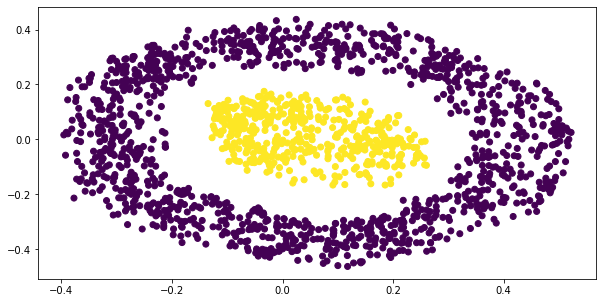

In [16]:
from scipy import linalg # lo vamos a necesitar para calcular los vectores y valores propios de la matriz Laplaciana
from sklearn.cluster import KMeans
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_circulos_concentricos.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False),:]
Dx = D[:,:2]
Dy = D[:,2]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = Dy)

Igual que antes, será necesario calcular la matriz de similitudes. Para ello, usaremos la función de la libreria Scikit-learn para obtener la matriz de distancias, concretamente, usando la métrica euclidiana. 

Para transformar la matriz de distancias en una de similitudes se usa la función exponencial de la siguiente manera:


In [17]:
from sklearn.metrics.pairwise import euclidean_distances

mSimilitud = euclidean_distances(Dx)

# recordad que sigma establece el "ancho de banda" que usaremos para convertir
# las distancias a una similitud entre 0 y 1.
sigma = 0.1
mSimilitud = np.exp(-np.power(mSimilitud,2)/(2*sigma**2))


Tal y como se ha visto en la parte teórica, el agrupamiento espectral consiste en 4 pasos básicos: 
-   la obtención de la matriz de adyacencias o afinidad, 
-   la obtención de la matriz Laplaciana, 
-   el cálculo de los vectores y valores propios de esta última, 
-   y el clustering mediante K-means (u otra técnica tradicional). 

Iremos paso a paso revisando los diferentes pasos.

Para comenzar, calcularemos la matriz de afinidad completa, que contempla que todos los ejemplos (nodos) están conectados con todos:


In [18]:
def matriz_afinidad_completa(mSimilitud):
    # matriz afinidad completa:
    mAfinidad = mSimilitud
    return mAfinidad


La matriz de afinidad mediante umbral sólo conecta aquellos nodos cuya similitud sea mayor que cierto umbral fijado. Todos aquellos pares de ejemplos (nodos) que superen el umbral reciben como valor $W_{ij}$ el valor de similitud correspondiente, y 0 cuando no están conectados:


In [19]:
def matriz_afinidad_umbral(mSimilitud, umbral=0.1):
    mAfinidad = np.zeros(mSimilitud.shape)
    # aplicamos el umbral
    mAfinidad[mSimilitud >= umbral] = mSimilitud[mSimilitud >= umbral]
    return mAfinidad


La matriz de afinidad mediante KNN sólo conecta aquellos nodos que sean uno de los ($K$) vecinos más cercanos (similares) entre ellos. Todos aquellos pares de ejemplos (nodos) que sean vecinos cercanos reciben como valor $W_{ij}$ el valor de similitud correspondiente, y 0 cuando no están conectados. Otra alternativa es calcular dos matrices, $W^1$ y $W^2$, tal que $W^1_{ij}$ toma valor 1 cuando el nodo $j$ es uno de los $K$ vecinos más similares de $i$, y $W^2_{ij}$ toma valor 1 cuando el nodo $i$ es uno de los K vecinos más similares de $j$. La matriz de afinidad devuelta sería $(W^1+W^2)/2$:


In [20]:
def matriz_afinidad_KNN(mSimilitud, KNN=5):
    auxM = mSimilitud.copy()
    np.fill_diagonal(auxM, 0)

    # Construimos la matriz afinidad de A a B
    mAfinidadA = np.zeros(auxM.shape)
    # utilizamos la matriz similitud para ordenar los vecinos de cada nodo por cercanía
    # `np.argsort` nos devuelve los índices que ordenan el array introducido (de forma ascendente)
    # en este caso, al tener la matriz similitud, tenemos que hacerla negativa, para que nos 
    # devuelva primero los más similares (que al ponerle el - a la matriz de similitud, son los
    # valores más pequeños)
    # Flatten simplemente lo utilizamos para convertir la matriz `KNN x n`en un vector de 1x(KNN x n)
    indices_kNN_nodo_fila = np.argsort(-auxM, axis=0)[0:KNN, :].flatten()
    # Nos creamos un array para combinar con el anterior y poder indexar los 
    # elementos pertinentes de la matriz de afinidad
    indices_kNN_nodo_col = np.tile(np.arange(auxM.shape[0]), KNN)
    mAfinidadA[indices_kNN_nodo_fila, indices_kNN_nodo_col] = 1
    np.fill_diagonal(mAfinidadA, 1)

    # Y ahora hacemos lo mismo de B a A
    mAfinidadB = np.zeros(auxM.shape)
    # Fijaos que en este caso la matriz va a ser `n x KNN` (hacemos el argsort en la dirección columnas: -->)
    indices_kNN_nodo_fila = np.repeat(np.arange(auxM.shape[0]), KNN)
    indices_kNN_nodo_col = np.argsort(-auxM, axis=1)[:, 0:KNN].flatten()
    mAfinidadB[indices_kNN_nodo_fila, indices_kNN_nodo_col] = 1
    np.fill_diagonal(mAfinidadB, 1)

    return (mAfinidadA + mAfinidadB) / 2


Una vez obtenida la matriz de afinidad, el siguiente paso es calcular una matriz Laplaciana. Como se ha visto en la parte teórica, hay tres manera de hacerlo.

La matriz Laplaciana no normalizada tiene, en cada celda $L_{ij}$, con $i\neq j$, el valor $-W_{ij}$, y en su diagonal principal $L_{ii}=D_{i}$, donde $D_i$ es la suma de $W_{ij}$ para toda la fila (para todo $j$).

Es decir: $L = D - W$, donde $L$ es la Laplaciana, $D$ es la matriz diagonal con $D_{ii} = \sum_j W_{ij}$ y $W$ es la matriz representativa del grafo, es decir, la matriz de afinidad.


In [21]:
def matriz_Laplaciana(mAfinidad):
    R = -mAfinidad.copy()
    np.fill_diagonal(R, np.sum(mAfinidad,axis=1)-1)
    return  np.diag(np.sum(mAfinidad, axis=1)) - mAfinidad ## Tu código aquí ##


La matriz Laplaciana normalizada (o de camino aleatorio) se calcula como la diferencia entre la matriz identidad y el producto de la inversa de la matriz diagonal de grado, $D$, y la matriz de afinidad. 

Es decir: $L = I - D^{-1}W$, donde $L$ es la Laplaciana normalizada, $I$ es la matriz identidad, $D$ es la matriz diagonal con $D_{ii} = \sum_j W_{ij}$ y $W$ es la matriz representativa del grafo, es decir, la matriz de afinidad.


In [22]:
def matriz_Laplaciana_normalizada(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D = D**(-1)
    I = np.diag( np.ones(D.size) )
    D = np.diag(D)
    return I-np.dot(D, mAfinidad)## Tu código aquí ##


Para obtener la matriz Laplaciana normalizada simétrica se calcula, $D'$ la inversa de la raiz cuadrada de la matriz diagonal de grado, $D$. El resultado final se obtiene tras calcular la diferencia entre la matriz identidad y el producto de $D'$, la matriz de afinidad y $D'$ de nuevo. 

Es decir: $L = I - D^{-1/2}WD^{-1/2}$, donde $L$ es la Laplaciana normalizada simétrica, $I$ es la matriz identidad, $D$ es la matriz diagonal con $D_{ii} = \sum_j W_{ij}$ y $W$ es la matriz representativa del grafo, es decir, la matriz de afinidad.

In [23]:
def matriz_Laplaciana_normalizada_simetrica(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D = D**(-1.0/2)
    I = np.diag( np.ones(D.size) )
    D = np.diag(D)
    L = I - np.dot( np.dot(D, mAfinidad), D  )
    return L  ## Tu código aquí ##


Con esto, sólo nos queda obtener los valores y vectores propios de la matriz Laplaciana, para lo que usaremos la función eig de la libraría scipy. Los primeros vectores propios, ordenados según su valor propio correspondiente, se recogen y se usan como variables de nuestro nuevo dataset, el conjunto de datos transformado que usaremos posteriormente para realizar el clustering K-means:


In [24]:
def agrupamiento_espectral(mSimilitud, K, afinidad = matriz_afinidad_completa, 
                           laplaciana = matriz_Laplaciana_normalizada, **kwargs):
    mAfinidad = afinidad(mSimilitud, **kwargs)
    mLaplaciana = laplaciana(mAfinidad)

    valores_pr, vectores_pr = linalg.eig(mLaplaciana)
    orden = valores_pr.real.argsort()
    vectores_pr = vectores_pr.real[:, orden]

    Dx_trans = vectores_pr[:, np.arange(K)]
    modelo = KMeans(n_clusters = K)
    modelo = modelo.fit(Dx_trans)
    Dyp = modelo.predict(Dx_trans)

    return [mAfinidad, Dyp]


Con esta última función, ya se puede proceder a realizar el agrupamiento:


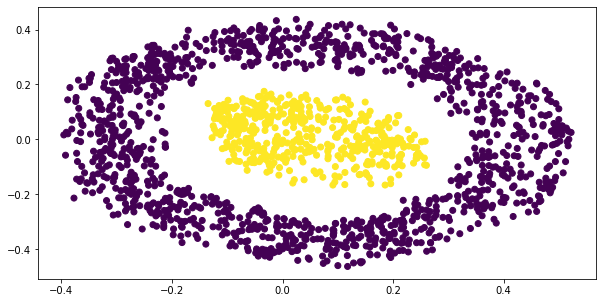

In [25]:
K = 2
knn = 40
mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                        matriz_afinidad_KNN,
                                        matriz_Laplaciana_normalizada, KNN=knn)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

# INICIO - NO TOCAR : necesario para la evaluación del notebook
answers['4'] = {'K': K, 'knn': knn,
                'mAfinidad': mAfinidad,
                'Dyp': Dyp,
                'fig': encode_figure(fig)}
# FIN - NO TOCAR : necesario para la evaluación del notebook


Otra manera de realizar el agrupamiento es usar la afinidad de umbral y la matriz normalizada:


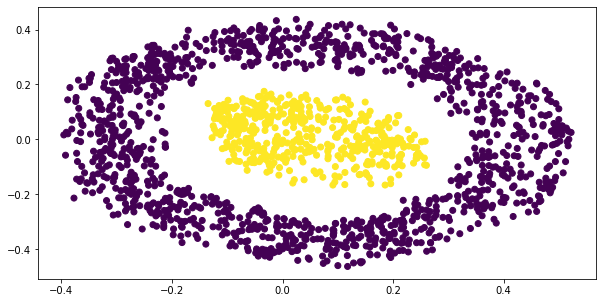

In [26]:
K = 2
eps = 0.8
mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                        matriz_afinidad_umbral,
                                        matriz_Laplaciana_normalizada, umbral=eps)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

# INICIO - NO TOCAR : necesario para la evaluación del notebook
answers['5'] = {'K': K, 'eps': eps,
                'mAfinidad': mAfinidad,
                'Dyp': Dyp,
                'fig': encode_figure(fig)}
# FIN - NO TOCAR : necesario para la evaluación del notebook


Una tercera prueba podría consistir en usar la afinidad completa y la matriz normalizada simétrica:


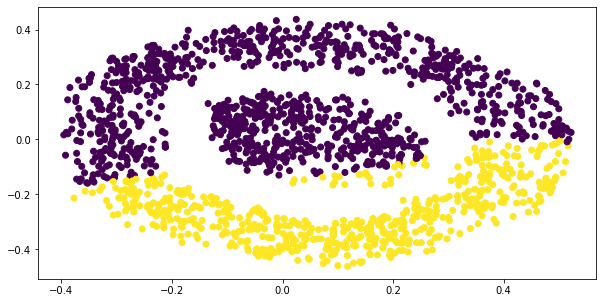

In [27]:
K = 2
mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                        matriz_afinidad_completa,
                                        matriz_Laplaciana_normalizada_simetrica)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

# INICIO - NO TOCAR : necesario para la evaluación del notebook
answers['6'] = {'K': K,
                'mAfinidad': mAfinidad,
                'Dyp': Dyp,
                'fig': encode_figure(fig)}
# FIN - NO TOCAR : necesario para la evaluación del notebook

### Se puede observar que este último ejemplo, esta combinación específica de parámetros para el algoritmo, no devuelve el restultado esperado. ¿Cuál es la razón? 

**ES NECESARIO CONTESTAR A ESTA PREGUNTA Y SUBIR EL NOTEBOOK**

In [28]:
# 2 - Se puede observar que este último ejemplo, esta combinación específica de parámetros para el algoritmo, no devuelve el restultado 
# esperado. ¿Cuál es la razón?

# a) El uso de la matriz de afinidad completa hace que todas las muestras se encuentren unidas entre si, por lo que resulta más complicado
# encontrar separaciones incluso utilizando la matriz laplaciana normalizada simétrica.
# b) El uso de la matriz laplaciana simétrica no permite separar correctamente los grupos, deberíamos utilizar la matriz laplaciana, que tiene
# mayor capacidad de separación
# c) Con los datos disponibles resulta imposible encontrar una combinación de parámetros que nos permitan separarlos correctamente.

respuesta = 'a' # a, b o c

# INICIO - NO TOCAR : necesario para la evaluación del notebook
answers['7'] = {'respuesta': respuesta}
# FIN - NO TOCAR : necesario para la evaluación del notebook

<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering espectral.

Están implementadas (parámetro affinity) las matrices de afinidad completa y KNN. Usa la matriz Laplaciana normalizada.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


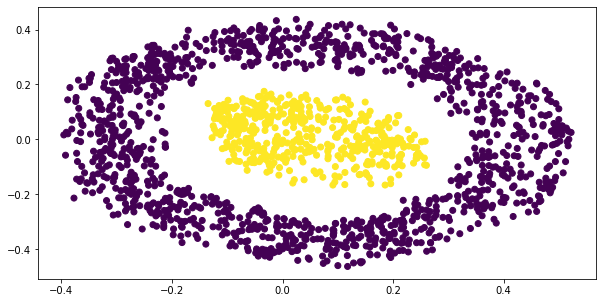

In [29]:
from sklearn.cluster import SpectralClustering
K = 2
knn = 5
clustering = SpectralClustering(n_clusters = K, 
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                random_state = 0).fit(Dx)

fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)

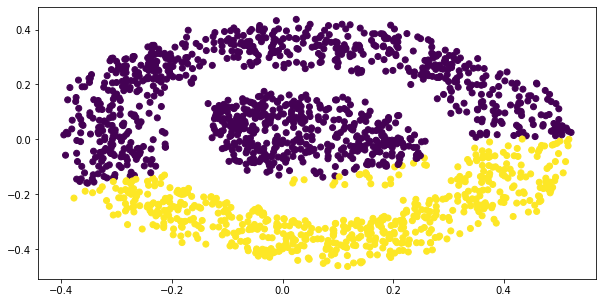

In [30]:
K=2
clustering = SpectralClustering(n_clusters = K, 
                                gamma=1./(2*sigma**2),
                                random_state = 0).fit(Dx)

fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)


Con la siguiente función dibujaremos los resultados del clustering (fijado un K) usando diferentes criterios. Podemos usar diferentes datasets de ejemplo (ver aquellos que tiene 2 dimensiones en:
https://github.com/flifuehu/viu-unsupervised-learning/tree/master/datasets

Podemos hacer unas pruebas para ganar algunas intuiciones sobre cuál es la mejor estrategia según el tipo de datos...


In [31]:
def plot_varios(Dx, Dy, K, knn=5, eps=0.8):
    mSimilitud = euclidean_distances(Dx)
    sigma = 0.1
    mSimilitud = np.exp(-np.power(mSimilitud,2)/(2*sigma**2))
    
    fig, ax = plt.subplots(2,3, figsize=(20,10))
    ax[0,0].scatter(Dx[:,0], Dx[:,1], c=Dy)
    ax[0,0].set_title('Datos originales')
    
    mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                            matriz_afinidad_KNN,
                                            matriz_Laplaciana, KNN=knn)
    ax[0,1].scatter(Dx[:,0], Dx[:,1], c=Dyp)
    ax[0,1].set_title('Laplaciana no normalizada, KNN')
    
    mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                            matriz_afinidad_completa,
                                            matriz_Laplaciana)
    ax[0,2].scatter(Dx[:,0], Dx[:,1], c=Dyp)
    ax[0,2].set_title('Laplaciana no normalizada, Completa')
    
    mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                            matriz_afinidad_umbral,
                                            matriz_Laplaciana_normalizada, umbral=eps)
    ax[1,0].scatter(Dx[:,0], Dx[:,1], c=Dyp)
    ax[1,0].set_title('Laplaciana normalizada, Umbral')
    
    mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                            matriz_afinidad_KNN,
                                            matriz_Laplaciana_normalizada, KNN=knn)
    ax[1,1].scatter(Dx[:,0], Dx[:,1], c=Dyp)
    ax[1,1].set_title('Laplaciana normalizada, KNN')
    
    mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                            matriz_afinidad_completa,
                                            matriz_Laplaciana_normalizada)
    ax[1,2].scatter(Dx[:,0], Dx[:,1], c=Dyp)
    ax[1,2].set_title('Laplaciana normalizada, Completa')

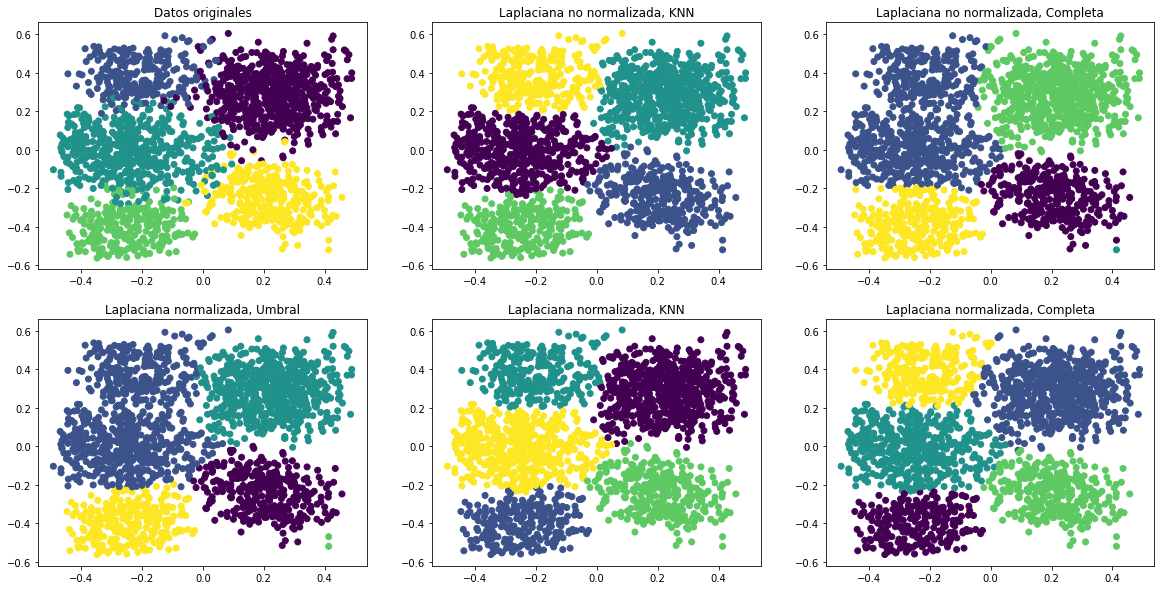

In [32]:
data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_inseparable.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
plot_varios(Dx,Dy,5)

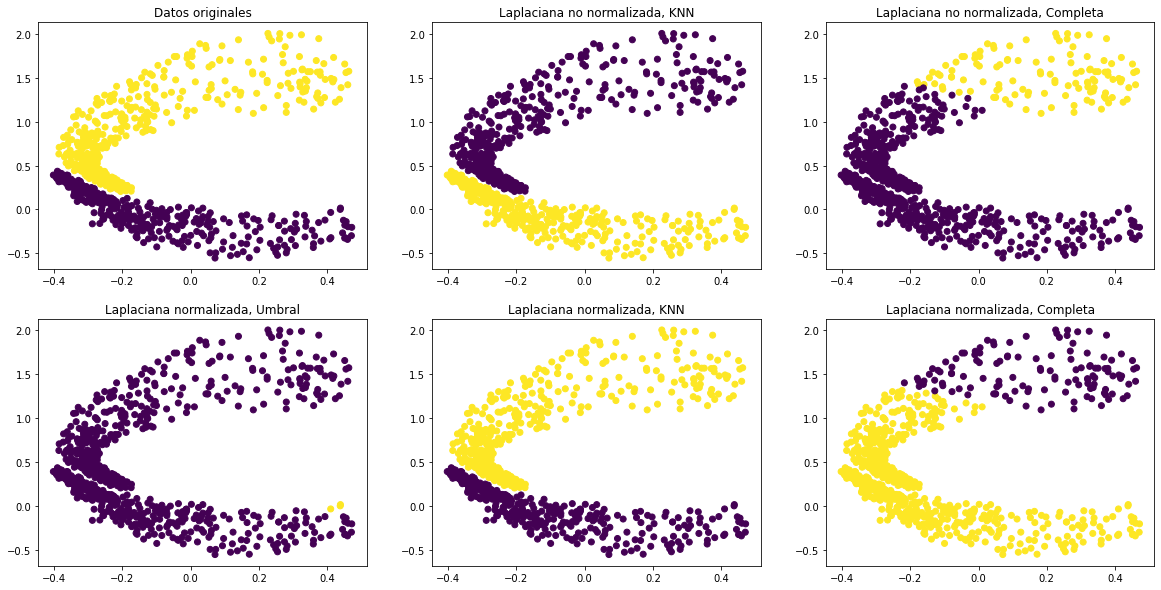

In [33]:
data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_dos_remolinos.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
plot_varios(Dx,Dy,2,knn=4)

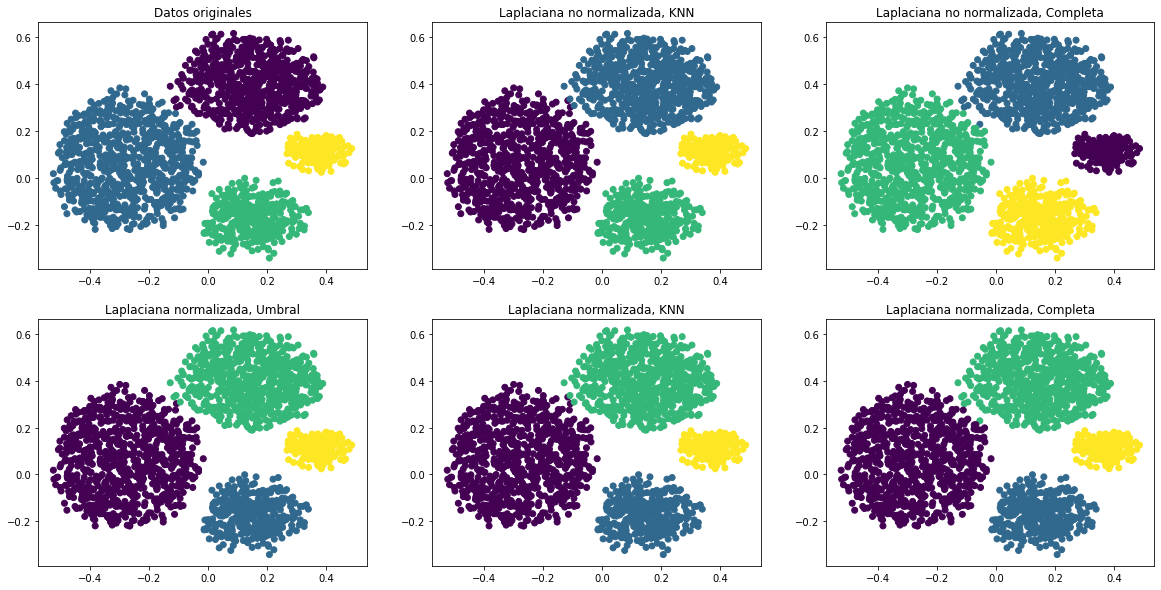

In [34]:
data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_cuatro_diferente_medida.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
plot_varios(Dx,Dy,4)

# RECUERDA EJECUTAR ESTA CELDA ÚNICAMENTE CUANDO HAYAS FINALIZADO EL NOTEBOOK

In [35]:
################################################################################
# ATENCIÓN, MUY IMPORTANTE: EJECUTA ESTA CELDA SIN MODIFICAR NADA!
#
# ESTA CELDA SE ENCARGA DE COMPRIMIR LOS RESULTADOS OBTENIDOS Y MANDARLOS
# AL SERVIDOR PARA SU VERIFICACIÓN Y ALMACENAJE.
#
# SI NO LA EJECUTAS, ¡¡¡NO PODRÁS SER EVALUADX!!!
################################################################################

import zmq
import base64
import pickle
import bz2
import sys

def send_results(answers):

    def compress_data(data):
        data_pkl = pickle.dumps(data)
        data_bz2 = bz2.compress(data_pkl)
        return data_bz2

    if NOMBRE == 'TuNombre' or APELLIDOS == 'TusApellidos' or \
    NOMBRE.strip() == '' or APELLIDOS.strip() == '':
        print('Rellena tu nombre y apellidos en la primera celda del notebook!')
    else:
        print('Conectando con el servidor de evaluación...', end='\t')
        context = zmq.Context()
        socket = context.socket(zmq.REQ)
        socket.connect(base64.b64decode(b'dGNwOi8vMTU4LjQyLjE3MC4xMzU6MzM4OQ==').decode('ascii'))
        print('OK')

        # Compressing data
        print('Comprimiendo las respuestas...', end='\t')
        data = compress_data(answers)
        print('OK')

        print('Enviando datos...', end='\t')
        socket.send(data)
        message = socket.recv()
        if message == data:
            print(f'OK')
            print('Entrega realizada con éxito! :)')
        else:
            print('ERROR! Por favor vuelve a ejecutar la celda. Si los problemas persisten ponte en contacto con el profesor.')    


send_results(answers)

Conectando con el servidor de evaluación...	OK
Comprimiendo las respuestas...	OK
Enviando datos...	OK
Entrega realizada con éxito! :)
